In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
import json
%matplotlib inline

In [2]:
class TableDetector:

    def __init__(self, verbose=False, strip_height=50, w_max_pool=50, min_col_width=50, ratio_clip_max=0.8):
        self.verbose = verbose
        self.state = 'Table_Search'
        self.state_machine = {'Table_Search':self.table_search, 
                              'Candidate_Table': self.candidate_table, 
                              'Table_Registered':self.table_registered, 
                              'Confirm_Table_End':self.confirm_table_end}
        self.tables = []
        self.reset_table_info()
        self.strip_height = strip_height
        self.w_max_pool = w_max_pool
        self.min_col_width = min_col_width
        self.ratio_clip_max = ratio_clip_max
        
    def reset_table_info(self):
        
        self.table_info = {}
        self.col_positions = []
        
    def table_search(self):
        '''
        if(self.verbose):
            print('Table_Search')
        '''
        if len(self.col_positions) > 0:      
            self.state = 'Candidate_Table'
            self.table_info['table_start'] = self.start
            self.table_info['col_positions'] = self.col_positions
            self.n_cols = len(self.col_positions)
            
        return
    
    def candidate_table(self):
        '''
        if(self.verbose):
            print('Candidate_Table')
        '''
        if len(self.col_positions) > 0:# and len(self.col_positions) == self.n_cols:      
            self.state = 'Table_Registered'
        else:
            self.state = 'Table_Search'
            self.reset_table_info()
        return
    
    def table_registered(self):
        '''
        if(self.verbose):
            print('Table_Registered')
        '''
        if len(self.col_positions) == 0:# or len(self.col_positions) != self.n_cols:
        #if len(self.col_positions) == 0:
            self.table_info['table_end'] = self.end
            self.state = 'Confirm_Table_End'
        return
    def confirm_table_end(self):
        '''
        if(self.verbose):
            print('Confirm_Table_End')
        '''
        if len(self.col_positions) == 0:# or len(self.col_positions) != self.n_cols:
        #if len(self.col_positions) != self.n_cols:
            self.state = 'Table_Search'
            
            self.tables.append(self.table_info)
            self.reset_table_info()
        else:
            self.state = 'Table_Registered'
        return
    
    def remove_false_cols(self, grads):
        #self.min_col_width = 50
        # Get all posititions of col starts

        col_starts = np.squeeze(np.argwhere(grads==1))
        # If dist between 2 1's < min_col_width--> set all to zeros until next 1 pos
        prev_pos = col_starts[0]
        for idx, pos in enumerate(col_starts):
            if idx > 0:
                dist = pos - prev_pos

                if dist < self.min_col_width:  
                    grads[pos] = 0
                else:                   
                    prev_pos = pos

        return grads   
    
    def remove_outliers(self, arr):
        arr[np.abs(arr-np.mean(arr)) > (3*np.std(arr))] = 0
        return arr
    
    def remove_consecutive(self, input): 
        # Get 1's pos
        ones = np.squeeze(np.argwhere(input == 1))
        # Get -1's pos
        neg_ones = np.squeeze(np.argwhere(input == -1))
        # Alternate from 1's and -1's. Always start by 1's
        result = []
        positive = True
        next_pos = 0
        for i in range(len(ones)):
            if positive:
                result.append(ones[next_pos])
                positive = False
                curr_pos = next_pos

                next_pos = np.squeeze(np.argwhere(neg_ones > ones[curr_pos])).tolist()# Alternate to the pos in neg_ones > curr_pos value in ones
                if isinstance(next_pos, list):
                    if len(next_pos) > 0:
                        next_pos = next_pos[0]
                    else:
                        break
                else:
                    next_pos = next_pos
            else:
                result.append(neg_ones[next_pos])
                positive = True
                curr_pos = next_pos

                next_pos = np.squeeze(np.argwhere(ones > neg_ones[curr_pos])).tolist()
                if isinstance(next_pos, list):
                    if len(next_pos) > 0:
                        next_pos = next_pos[0]
                    else:
                        break
                else:
                    next_pos = next_pos

        mask = np.zeros(len(input), dtype=int)
        if(len(result) > 0):
            mask[np.array(result)] = input[np.array(result)]

        return mask 
    
    def maxpool1D(self, h, w):
        max_thresh = 3
        n_w = int(len(h)/w)
        h_maxes = np.zeros(len(h))
        for i in range(n_w):

            #h_maxes[i*w:(i+1)*w] = np.mean(h[i*w:(i+1)*w])
            #h_maxes[i*w:(i+1)*w] = max(h[i*w:(i+1)*w]) 
            
            local_max = max(h[i*w:(i+1)*w])
            if(local_max > max_thresh):
                h_maxes[i*w:(i+1)*w] = max(h[i*w:(i+1)*w]) 
            else:
                h_maxes[i*w:(i+1)*w] = 0
            
        return h_maxes    
    
    def zero_crossings(self, h_maxes):
        res = 0 * h_maxes
        pos = h_maxes > 0
        pos2neg_positions = (~pos[:-1] & pos[1:]).nonzero()[0]
        neg2pos_positions = (pos[:-1] & ~pos[1:]).nonzero()[0]
        res[pos2neg_positions] = 1
        res[neg2pos_positions] = -1
        return res
    
    def clean_grads(self, grads):
        # TODO: outliers removal
        #grads[np.abs(grads-np.mean(grads)) > (3*np.std(grads))] = 0
        #grads = self.remove_outliers(grads)
        
        # Adaptive threshold = max*ratio       
        thresh = np.max(grads)*self.ratio_clip_max   
        global_thresh = 2
        
        #grads[grads < global_thresh] = 0
        
        # Filter pos values
        filter_pos_idx = np.squeeze(np.argwhere(np.logical_and((grads > 0), (grads <= thresh))))
        grads[filter_pos_idx] = 0

        # Filter neg values
        filter_neg_idx = np.squeeze(np.argwhere(np.logical_and((grads < 0), (grads >= -thresh))))
        grads[filter_neg_idx] = 0

        # Normalize thr grads to 1/-1
        grads[grads < 0] = -1
        grads[grads > 0] = 1

        # Remove consecutive 1's or -1's
        grads = self.remove_consecutive(grads)

        return grads  
    
    def preprocess_row(self, img_strip):

        # 1. Histo projection
        h_all = np.sum(img_strip, axis=0)
        h_all = self.remove_outliers(h_all)
        # 2. Maxpool1D
        h_maxes = self.maxpool1D(h_all, w=self.w_max_pool)
        #h_maxes = self.remove_outliers(h_maxes)
        # 3. Gradients
        g = np.gradient(h_maxes)
        # 4. Clean grads
        g_clean = self.clean_grads(g.copy())   
        
        #g_clean = g
        if verbose:
            self.h = h_maxes.copy()
            #self.g = g_clean.copy()
            self.g = g_clean.copy()
            
        
        return g_clean
    
    def check_row_pattern(self, row_grads):
        #self.g = 0*row_grads.copy()
        if len(np.argwhere(row_grads==1)) >= 2:

            # If dist between 2 1's < min_col_width--> set all to zeros
            row_grads = self.remove_false_cols(row_grads)
            #self.g = row_grads.copy()
            # Count 1's => 2
            if len(np.argwhere(row_grads==1)) >= 2:
                col_positions = np.squeeze(np.argwhere(row_grads==1))                   

            else:
                col_positions = []
        else:
            col_positions = []

        return col_positions
    
    def row_pattern_detect(self, img_strip):
        g_clean = self.preprocess_row(img_strip)
        col_positions = self.check_row_pattern(g_clean)

        self.col_positions = col_positions.copy()

        return col_positions
    
    def adjust_tables_boundaries(self, img):
        H, W = img.shape
        
        for table in self.tables:
            table['table_start'] = table['table_start'] - self.strip_height
            table['table_end'] = table['table_end'] - self.strip_height
            last_col = W - table['col_positions'][0]
            table['col_positions'] = np.append(table['col_positions'], last_col)
        
        return tables
    
    def run(self, img):
        
        H, W = img.shape
        n_strips = int(np.floor(H/self.strip_height))
        #overlap = 0.5
        
        for i in range(n_strips):
            self.start = i*self.strip_height
            self.end = self.start + self.strip_height
            img_strip = img[self.start:self.end, :] 
            col_positions = self.row_pattern_detect(img_strip)
            self.state_machine[self.state]()
            if self.verbose:
                fig = plt.figure()    
                # Show the orig image with the strip on col 1
                ax = fig.add_axes([0,0,1,1])
                rect = patches.Rectangle((0,self.start), W, self.strip_height, linewidth=1, edgecolor='r', facecolor='none')
                
                
                ax.add_patch(rect)
                
                ax.imshow(img_orig, cmap='gray')
                fig.savefig('images/' + file_name + '_image_stip_' + str(i) + '_table.jpg')
                #fig.clf()
                
                fig = plt.figure()    
                ax = fig.add_subplot(211)
                n_cols = len(col_positions)
                ax.text(10,0,self.state + ', n_cols: ' + str(col_positions))#str(n_cols))
                #ax.text(10,100,str(col_positions))
                ax.plot(self.h)    
                # Show next the cleaned up grad or histogram
                ax = fig.add_subplot(212)
                ax.plot(self.g)    
                #plt.imsave(file_name + '_' + str(i) + '_table.jpg', fig, cmap='gray')
                fig.savefig('plots/' + file_name + '_plots_' + str(i) + '_table.jpg')
                #fig.savefig(file_name + '_' + str(i) + '_table.jpg')
                #fig.clf()
        
        self.tables = self.adjust_tables_boundaries(img)
        
        return self.tables
   
    def visualize_tables(self, img_orig, file_name):
        tables = self.tables
        tables_img = img_orig
        line_width = 10
        fig = plt.figure()
        for table in tables:
            #table_start = table['table_start'] - self.strip_height
            #table_end = table['table_end'] - self.strip_height
            table_start = table['table_start'] - self.strip_height
            table_end = table['table_end'] - self.strip_height
            # Last colomn boundary = min(img_boundary, last_col_start + spacing of the previous colomn)
            #last_col = min(tables_img.shape[1], table['col_positions'][-1] + (table['col_positions'][-1] - table['col_positions'][-2]))
            last_col = tables_img.shape[1] - table['col_positions'][0]
            # Draw table boundaries
            tables_img[table_start-line_width:table_start+line_width, table['col_positions'][0] : last_col] = 0
            tables_img[table_end-line_width:table_end+line_width, table['col_positions'][0] : last_col] = 0
            # Draw cols
            for col in table['col_positions']:

                tables_img[table_start:table_end, col-line_width:col+line_width] = 0
            # Left boundary
            tables_img[table_start:table_end, last_col-line_width:last_col+line_width] = 0
        plt.imshow(tables_img, cmap='gray')
        plt.imsave(file_name + '_table.jpg', tables_img, cmap='gray')      
        return
    
    def save_json(self, file_name):
            
        output_file = open(file_name + '.json', 'w')
        for table in self.tables:
            print(table)
            json.dump(table, output_file) 
            output_file.write("\n")  
            
        return    
       

In [3]:

#dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"
dat_path = "../../../dat"

In [4]:
#file_name = 'Page 3.jpg' # OK
#file_name = 'Page 5.jpg' # OK
#file_name = 'Page 7.jpg' # OK
#file_name = 'Page 8.jpg' # NOK
file_name = 'Page 3.tiff' # NOK
#file_name = 'Page 3_mod.tiff' # NOK
#file_name = 'Page 3_mod_no_table.tiff' # NOK

img_orig = cv2.imread(os.path.join(dat_path, file_name), 0)
img = (255 - img_orig.copy())/255
img = img[:, :-100]

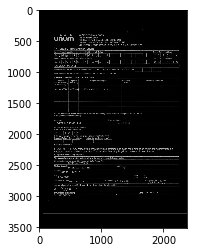

In [5]:
plt.imshow(img,cmap='gray')

In [6]:
img.shape

(3508, 2379)

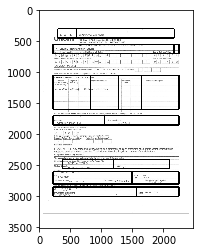

In [7]:
verbose = False
# 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.5)
tables = tables_detector.run(img)
tables_detector.visualize_tables(img_orig, file_name)
#tables_detector.save_json(file_name)

In [8]:
tables

[{'table_start': 350, 'col_positions': array([299, 599]), 'table_end': 500},
 {'table_start': 600, 'col_positions': array([ 224, 2174]), 'table_end': 750},
 {'table_start': 1100,
  'col_positions': array([ 224,  824, 1274, 1649]),
  'table_end': 1650},
 {'table_start': 1750,
  'col_positions': array([ 224, 1049]),
  'table_end': 1900},
 {'table_start': 2450,
  'col_positions': array([ 374, 1199]),
  'table_end': 2600},
 {'table_start': 2650,
  'col_positions': array([ 224, 1499]),
  'table_end': 2850},
 {'table_start': 2900,
  'col_positions': array([ 224, 1574]),
  'table_end': 3050}]

In [22]:
pdf_file_name = 'Accident-Handwritten_V3.pdf'
base_file_name = os.path.splitext(pdf_file_name)[0]
page_num = 3
# Convert pdf to tiff
#cmd = 'convert -density 300 ' + pdf_file_name + '[' + str(page_num-1) + ']' + ' ' + base_file_name+'.tiff'
cmd = 'convert -density 300 ' + pdf_file_name + ' ' + base_file_name+'.tiff'
os.system(cmd)

# Convert tiff to pdf sandwitch
cmd = 'tesseract' + ' ' + base_file_name+'.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
os.system(cmd)

# Convert pdf sandwitch to xml
xml_file = base_file_name+'.xml'
cmd = 'pdftohtml -c -hidden -xml' + ' ' + base_file_name+'_pdf_sand.pdf' + ' ' + xml_file
os.system(cmd)

0

 http://127.0.0.1:8080/pdf2xml-viewer.html.

In [15]:
#!python3 -m http.server 8080 --bind 127.0.0.1

Serving HTTP on 127.0.0.1 port 8080 (http://127.0.0.1:8080/) ...
127.0.0.1 - - [06/Oct/2018 09:43:34] code 404, message File not found
127.0.0.1 - - [06/Oct/2018 09:43:34] "GET /pdf2xml-viewer.html HTTP/1.1" 404 -
127.0.0.1 - - [06/Oct/2018 09:43:35] code 404, message File not found
127.0.0.1 - - [06/Oct/2018 09:43:35] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [06/Oct/2018 09:43:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2018 09:43:54] code 404, message File not found
127.0.0.1 - - [06/Oct/2018 09:43:54] "GET /favicon.ico HTTP/1.1" 404 -
^C

Keyboard interrupt received, exiting.


In [1]:
from pdftabextract.common import read_xml, parse_pages

# Load the XML that was generated with pdftohtml
#xmltree, xmlroot = read_xml(os.path.join(dat_path, xml_file))
xmltree, xmlroot = read_xml(xml_file)

# parse it and generate a dict of pages
pages = parse_pages(xmlroot)

p = pages[page_num]

#print(p['texts'][:3])


NameError: name 'xml_file' is not defined

In [ ]:
table = tables[3]
page_colpos = table['col_positions']

In [ ]:
# right border of the last column
last_rightborder = page_colpos[-1]

# calculate median text box height
median_text_height = np.median([t['height'] for t in p['texts']])

# get all texts in all the with a "usual" textbox height
# we will only use these text boxes in order to determine the line positions

text_height_deviation_thresh = median_text_height / 2
texts_cols = [t for t in p['texts']
                  if t['right'] <= last_rightborder
                     and abs(t['height'] - median_text_height) <= text_height_deviation_thresh]

In [ ]:
# Next we get the text boxes' top and bottom border positions, cluster them, and calculate the cluster centers.
from pdftabextract.clustering import zip_clusters_and_values
from pdftabextract.textboxes import border_positions_from_texts, split_texts_by_positions, join_texts
from pdftabextract.common import all_a_in_b, DIRECTION_VERTICAL

# get all textboxes' top and bottom border positions
borders_y = border_positions_from_texts(texts_cols, DIRECTION_VERTICAL)

# break into clusters using half of the median text height as break distance
clusters_y = find_clusters_1d_break_dist(borders_y, dist_thresh=median_text_height/2)
clusters_w_vals = zip_clusters_and_values(clusters_y, borders_y)

# for each cluster, calculate the median as center
pos_y = calc_cluster_centers_1d(clusters_w_vals)
pos_y.append(p['height'])

print('number of line positions:', len(pos_y))

In [ ]:
top_y = table['table_start']

In [ ]:
bottom_y = table['table_end']

In [ ]:
# finally filter the line positions so that only the lines between the table top and bottom are left
page_rowpos = [y for y in pos_y if top_y <= y <= bottom_y]

print("> page %d: %d lines between [%f, %f]" % (p_num, len(page_rowpos), top_y, bottom_y))

In [2]:
## 7. Create a grid of columns and lines

# From the column and row positions that we detected, we can now generate a "page grid" which should resemble the table layout as close as possible. We then save the grid information as JSON file so that we can display it in pdf2xml-viewer.

In [ ]:
from pdftabextract.extract import make_grid_from_positions

grid = make_grid_from_positions(page_colpos, page_rowpos)
n_rows = len(grid)
n_cols = len(grid[0])
print("> page %d: grid with %d rows, %d columns" % (p_num, n_rows, n_cols))


In [ ]:
# the page grid is a 2D matrix that contains the rectangular table cells
# this is the top left table cell:
grid[0][0]

In [ ]:
## 8. Match the text boxes into the grid and hence extract the tabular data in order to export it as Excel and CSV file

# We can use `fit_texts_into_grid` to fit the text boxes into the grid and then transform it to a [pandas](http://pandas.pydata.org/) *DataFrame*.

In [ ]:
from pdftabextract.extract import fit_texts_into_grid, datatable_to_dataframe

datatable = fit_texts_into_grid(p['texts'], grid)
    
df = datatable_to_dataframe(datatable)

df.head(n=30)

In [ ]:
df.to_json(base_file_name+'.json')